In [32]:
import pandas as pd
import numpy as np
import os
import glob
import logging
import itertools

import warnings
warnings.filterwarnings('ignore')

# import gensim
# from gensim.utils import file_or_filename, simple_preprocess
# from gensim.corpora.wikicorpus import _extract_pages, filter_wiki
# from gensim.parsing.preprocessing import STOPWORDS
# logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
# logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore

def head(stream, n=10):
    """Convenience fnc: return the first `n` elements of the stream, as plain list."""
    return list(itertools.islice(stream, n))

#from gensim.models import CoherenceModel, LdaModel, HdpModel

import matplotlib as mplib
import matplotlib.pyplot as plt # visualization package 1
import seaborn as sns           # visualization package 2
import matplotlib.ticker as ticker
# so images get plotted in the notebook
%matplotlib inline

import random

%pip install --quiet nltk
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 200)

# text analysis tools
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import preprocessing
from nltk import SnowballStemmer
import string

#downloading stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dingruiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
#https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
#evaluate coherence
translator=str.maketrans(string.punctuation, ' ' * len(string.punctuation))
string.punctuation
stemmer = SnowballStemmer("english")

stop_words = set(stopwords.words('english'))

#this will be used in CountVectorizer
def tokenize(text):
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))  # translator that replaces punctuation with empty spaces
    return [stemmer.stem(i) for i in text.translate(translator).split()]  # stemmer and tokenizing into words

# Tokenize stop words to match 
stop_words = [tokenize(s)[0] for s in stop_words]

stop = stop_words + ['provid', 'use', 'studi', 'and', 'the', 'was', 'with', 'of', 'has', 'have', 'had', 'will', 
                     'an', 'may', 'a', 'or', 'be', 'to', 'to the', 'and the', 'embodi', 'may be', 'be',
                    'coupl to the', 'coupl', 'coupl to', 'of a', 'first', 'second', 'a first', 'the first', 'a second', 'least',
                     'at least', 'at', 'plural', 'plural of', 'present', 'the present', 'invent', 'more']
full_stopwords = [tokenize(s)[0] for s in stop]



def n_grams_vectorizer(ngram):
    vectorizer = CountVectorizer(analyzer="word",        # unit of features are single words rather than characters
                                tokenizer=tokenize,      # function to create tokens
                                ngram_range=(0,int(ngram)),       # change num of words co-located
                                strip_accents='unicode', # remove accent characters
                                min_df = 0.05,           # only include words with minimum frequency of 0.05
                                max_df = 0.95)           # only include words with maximum frequency of 0.95
    return vectorizer

def topic_generator(text_list, num_topics):
# Creating bag of words
    bag_of_words = vectorizer.fit_transform(text_list)  # transform our corpus as a bag of words
    features = vectorizer.get_feature_names()                # get features (words)

    # Use TfidfTransformer to re-weight bag of words
    transformer = TfidfTransformer(norm = None, smooth_idf = True, sublinear_tf = True)
    tfidf = transformer.fit_transform(bag_of_words)

    # Fitting LDA model
    lda = LatentDirichletAllocation(n_components = num_topics, 
                                    learning_method='online',
                                   random_state=42) #adjust n_components
    doctopic = lda.fit_transform(tfidf)

    # Displaying the top keywords in each topic
    ls_keywords = []
    for i,topic in enumerate(lda.components_):
        word_idx = np.argsort(topic)[::-1][:5]
        keywords = ', '.join(features[i] for i in word_idx)
        ls_keywords.append(keywords)
        print(i, keywords) 
    return doctopic, ls_keywords

In [34]:
path = "C:/Users/achen/"

patent_2010_2018 = []
for year in list(range(2012,2019)):
    patent = pd.read_csv('Patents/patents_' + str(year) + '.csv', low_memory=False, skipinitialspace=True) 
    patent_2010_2018.append(patent)  # append that dataframe to a list

# Concatenate all the dataframes together into one dataframe
patent_2010_2018_df = pd.concat(patent_2010_2018)
patent_2010_2018_df.to_csv('patent_2010_2018_df.csv', encoding='utf8')

## If concatenated patent files, start here:

In [35]:
patents_df=pd.read_csv('patent_2010_2018_df.csv', skipinitialspace=True)
print(patents_df.columns)
patents_df['patent_abstract']=patents_df['patent_abstract'].str.lower()
#patents_df['patent_abstract'].isna().sum()  #patent abstracts have 88970 NaN values

Index(['Unnamed: 0', 'patent_number', 'patent_title', 'patent_abstract',
       'patent_num_cited_by_us_patents', 'patent_date', 'app_date',
       'patent_firstnamed_inventor_name_first',
       'patent_firstnamed_inventor_name_last',
       'patent_firstnamed_inventor_city', 'patent_firstnamed_inventor_state',
       'patent_firstnamed_inventor_latitude',
       'patent_firstnamed_inventor_longitude',
       'patent_firstnamed_assignee_organization',
       'patent_firstnamed_assignee_city', 'patent_firstnamed_assignee_state',
       'patent_firstnamed_assignee_latitude',
       'patent_firstnamed_assignee_longitude'],
      dtype='object')


In [36]:
patents_df['Patent_Year']=pd.to_datetime(patents_df['patent_date']).dt.year
patents_df['patent_abstract']=patents_df['patent_abstract'].str.lower()
patents_df['patent_title']=patents_df['patent_title'].str.lower()

In [37]:
#filter patents based on the titles
patents_df['patent_title']=patents_df['patent_title'].str.lower()
#filter out the abstracts that are NaN, and look at the titles instead
patents_title_filter=patents_df[patents_df['patent_abstract'].isna()] 
RE_patents_df1=patents_title_filter[patents_title_filter['patent_title'].str.contains(' solar | wind power | wind turbine | biomass | biofuel | geothermal')]

#filter patents based on the abstracts
patents_df['patent_abstract']=patents_df['patent_abstract'].str.lower()
upd_pas=patents_df.dropna(subset=['patent_abstract'])
RE_patents_df2=upd_pas[upd_pas['patent_abstract'].str.contains(' solar | wind power | wind turbine | biomass | biofuel | geothermal')]

print(len(RE_patents_df1)) #based on title
print(len(RE_patents_df2)) #based on abstract

92
5334


In [38]:
#RE_patents_df1
#RE_patents_df2 #need to use LDA processing; some abstracts just mention a renewable energy type, but may not necessarily have a relation

In [39]:
#Look at PIs in dataset with abstracts not nan throughout all years
RE_types=['solar', 'wind power | wind turbine','biomass | biofuel','geothermal']
PI_patents=RE_patents_df2.groupby(['patent_firstnamed_inventor_name_first','patent_firstnamed_inventor_name_last'])['patent_number'].nunique()
PI_df=PI_patents.to_frame().reset_index()
PI_df=PI_df.rename(columns={'patent_firstnamed_inventor_name_first':'first_name','patent_firstnamed_inventor_name_last':'last_name','patent_number':'number of patents'})
top_10_PIs=PI_df.sort_values(by='number of patents', ascending=False).head(10)
top_10_PIs.reset_index(drop=True)

,first_name,last_name,number of patents
0,Joseph Broun,Powell,53
1,Marshall,Medoff,44
2,Aniket V.,Kale,33
3,Roy,McAlister,30
4,Michael C.,Cheiky,29
5,Gabriel,Harley,19
6,Kyle L.,Fujdala,19
7,Mehrdad M.,Moslehi,19
8,Ming,Qiao,17
9,David D.,Smith,17


In [40]:
#Filter the time periods from the patent abstract data 
ARRA_patents=RE_patents_df2[RE_patents_df2['Patent_Year'].between(2012,2016)]
Post_ARRA_patents=RE_patents_df2[RE_patents_df2['Patent_Year'].between(2017,2018)]

In [41]:
#Top 10 PIs who obtained patents after ARRA stimulus
PI_patents=ARRA_patents.groupby(['patent_firstnamed_inventor_name_first','patent_firstnamed_inventor_name_last'])['patent_number'].nunique()
PI_df=PI_patents.to_frame().reset_index()
PI_df=PI_df.rename(columns={'patent_firstnamed_inventor_name_first':'first_name','patent_firstnamed_inventor_name_last':'last_name','patent_number':'number of patents after ARRA'})
top_10_PIs_ARRA=PI_df.sort_values(by='number of patents after ARRA', ascending=False).head(10)
top_10_PIs_ARRA.reset_index(drop=True)

,first_name,last_name,number of patents after ARRA
0,Joseph Broun,Powell,36
1,Aniket V.,Kale,33
2,Roy,McAlister,26
3,Marshall,Medoff,24
4,Michael C.,Cheiky,23
5,Kyle L.,Fujdala,19
6,Bulent M.,Basol,16
7,Mehrdad M.,Moslehi,16
8,Theodora,Retsina,14
9,Robert,Bartek,13


In [42]:
#Top 10 PIs who obtained patents after post-ARRA stimulus
PI_patents=Post_ARRA_patents.groupby(['patent_firstnamed_inventor_name_first','patent_firstnamed_inventor_name_last'])['patent_number'].nunique()
PI_df=PI_patents.to_frame().reset_index()
PI_df=PI_df.rename(columns={'patent_firstnamed_inventor_name_first':'first_name','patent_firstnamed_inventor_name_last':'last_name','patent_number':'number of patents after post-ARRA'})
top_10_PIs_post_ARRA=PI_df.sort_values(by='number of patents after post-ARRA', ascending=False).head(10)
top_10_PIs_post_ARRA.reset_index(drop=True)

,first_name,last_name,number of patents after post-ARRA
0,Marshall,Medoff,20
1,Joseph Broun,Powell,17
2,Richard Hamilton,Sewell,9
3,Benjamin,Harvey,8
4,Alexander W.,Au,8
5,Thomas P.,Pass,7
6,Gabriel,Harley,7
7,Ashok,Chaudhari,6
8,John Setel,O'Donnell,6
9,Ming,Qiao,6


Merge the two dataframes based on the same first name and last name of the PIs. This table image is used on slide 15 of our presentation.

In [43]:
merged_tp=pd.merge(top_10_PIs_ARRA, top_10_PIs_post_ARRA, on=['first_name', 'last_name'], how='inner')
merged_tp

,first_name,last_name,number of patents after ARRA,number of patents after post-ARRA
0,Joseph Broun,Powell,36,17
1,Marshall,Medoff,24,20


We can see that these are the two PIs with the most consistent number of patents generated through the time periods we are investigating

In [44]:
JPB_patents_A=ARRA_patents[(ARRA_patents['patent_firstnamed_inventor_name_first']=='Joseph Broun') & (ARRA_patents['patent_firstnamed_inventor_name_last']=='Powell')]
JPB_patents_pA=Post_ARRA_patents[(Post_ARRA_patents['patent_firstnamed_inventor_name_first']=='Joseph Broun') & (Post_ARRA_patents['patent_firstnamed_inventor_name_last']=='Powell')]
MM_patents_A=ARRA_patents[(ARRA_patents['patent_firstnamed_inventor_name_first']=='Marshall') & (ARRA_patents['patent_firstnamed_inventor_name_last']=='Medoff')]
MM_patents_pA=Post_ARRA_patents[(Post_ARRA_patents['patent_firstnamed_inventor_name_first']=='Marshall') & (Post_ARRA_patents['patent_firstnamed_inventor_name_last']=='Medoff')]

In [45]:
#this function will help transform the detailed topics into a dataframe which we can use to graph 
def patent_topic_details(input_df):
    topics_doc = pd.DataFrame(doctopic, columns = ls_keywords)
    #topics_doc.head()
    topics_doc.reset_index(drop=True, inplace=True)
    input_df.reset_index(drop=True, inplace=True)
    topic_patent_abs=pd.concat([topics_doc, input_df], axis=1)
    #topic_patent_abs.head(2)
    topics_doc.idxmax(axis=1) #this gives the index column name of max score in the column
    doc_topics_project_id_with_max = pd.concat([topics_doc.idxmax(axis=1),RE_patents_df2],axis=1).rename(columns={0:'topic'})
    #doc_topics_project_id_with_max.head(2)
    topic_list=list(doc_topics_project_id_with_max.topic.unique())
    patent_counts_dict={}
    for t in topic_list:
        patent_counts_dict[t]=len(doc_topics_project_id_with_max[doc_topics_project_id_with_max['topic']==t])
    patent_counts_df=pd.DataFrame([patent_counts_dict])
    patent_counts_df=patent_counts_df.transpose()
    patent_counts_df.rename(columns={0:'num_patents'}, inplace=True)
    patent_counts_df.sort_values(by='num_patents', inplace=True)
    patent_counts_df=patent_counts_df[patent_counts_df['num_patents']!=0]
    return patent_counts_df

Let's first look at the large patent topics after ARRA (2012-2016). This image of topics was used on slide 15 of our presentation.

In [46]:
ARRA_patents_abstracts=ARRA_patents['patent_abstract'].values.tolist()
vectorizer=n_grams_vectorizer(2) #choose number of n-grams
doctopic, ls_keywords=topic_generator(ARRA_patents_abstracts, 4) 

0 plural, plural of, to, assembl, wind
1 biomass, and, of, process, in
2 solar cell, cell, layer, first, second
3 power, system, may, solar, or


Let's now look at the large patent topics after post-ARRA (2017-2018). This image of topics was used on slide 15 of our presentation.

In [47]:
Post_ARRA_patents_abstracts=Post_ARRA_patents['patent_abstract'].values.tolist()
vectorizer=n_grams_vectorizer(2) #choose number of n-grams
doctopic, ls_keywords=topic_generator(Post_ARRA_patents_abstracts, 4) 

0 power, wind, turbin, system, wind turbin
1 biomass, and, to, of, in
2 cell, solar cell, layer, substrat, metal
3 first, second, panel, solar, solar panel


**We can see that the broad topics are approximately the same when comparing the time periods of interest**

**Now we wanted to know the details of the patents that the top 2 consistent PIs: JBP and MM produced**

JBP after ARRA

In [48]:
JPB_patents_A_abstracts=JPB_patents_A['patent_abstract'].values.tolist()
vectorizer=n_grams_vectorizer(2) #choose number of n-grams
doctopic, ls_keywords=topic_generator(JPB_patents_A_abstracts, 5) 

0 fluid, outlet, communic, fluid communic, in fluid
1 biomass solid, cellulos, cellulos biomass, digest, solid
2 have, time, catalyst, have a, support
3 support, stabil, phase stabil, stabil test, test
4 hydrocatalyt, hydrotherm hydrocatalyt, the biomass, that, hydrotherm


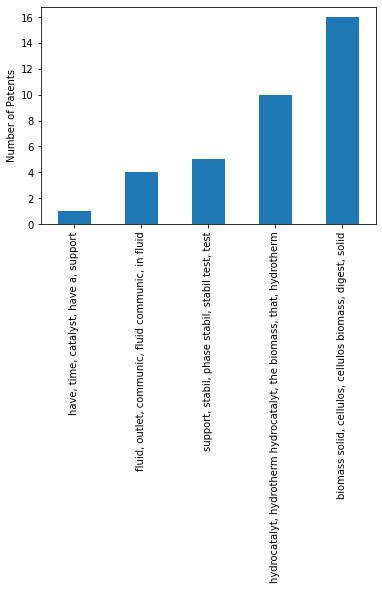

In [51]:
patent_counts_df=patent_topic_details(JPB_patents_A)
patent_counts_df.plot(kind='bar', legend=None)
plt.ylabel('Number of Patents')
plt.savefig('JBP_after_ARRA.png', bbox_inches='tight')
plt.show()

JBP after post-ARRA

In [53]:
JPB_patents_pA_abstracts=JPB_patents_pA['patent_abstract'].values.tolist()
vectorizer=n_grams_vectorizer(2) #choose number of n-grams
doctopic, ls_keywords=topic_generator(JPB_patents_pA_abstracts, 5) 

0 further, product, molecular weight, weight compound, unconvert
1 continu, the continu, continu liquid, phase, gas
2 phase, biomass solid, solid, phenol liquid, the cellulos
3 mixtur, product mixtur, least one, reaction, one
4 the biomass, hydrocatalyt, hydrotherm hydrocatalyt, hydrotherm, that


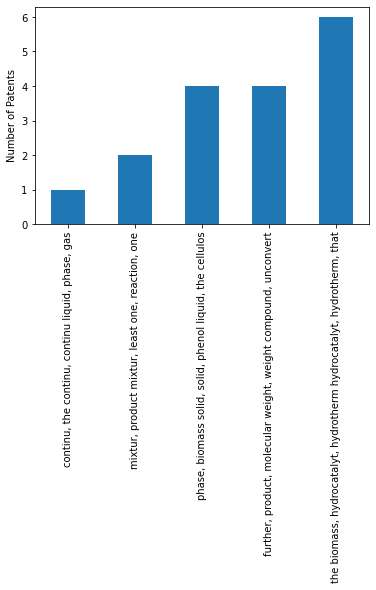

In [54]:
patent_counts_df=patent_topic_details(JPB_patents_pA)
patent_counts_df.plot(kind='bar', legend=None)
plt.ylabel('Number of Patents')
plt.savefig('JBP_after_post_ARRA.png', bbox_inches='tight')
plt.show()

MM after ARRA

In [55]:
MM_patents_A_abstracts=MM_patents_A['patent_abstract'].values.tolist()
vectorizer=n_grams_vectorizer(2) #choose number of n-grams
doctopic, ls_keywords=topic_generator(MM_patents_A_abstracts, 5) 

0 cool, conveyor, the biomass, conveyor can, the conveyor
1 sand, materi such, materi, and or, or
2 feedstock, to produc, biomass feedstock, saccharifi, a
3 facil, product facil, transport, ethanol product, made
4 the product, product of, of, by ferment, g the


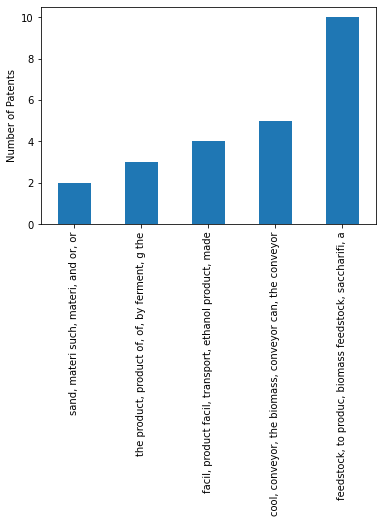

In [56]:
patent_counts_df=patent_topic_details(MM_patents_A)
patent_counts_df.plot(kind='bar', legend=None)
plt.ylabel('Number of Patents')
plt.savefig('MM_after_ARRA.png', bbox_inches='tight')
plt.show()

MM after post-ARRA

In [57]:
MM_patents_pA_abstracts=MM_patents_pA['patent_abstract'].values.tolist()
vectorizer=n_grams_vectorizer(2) #choose number of n-grams
doctopic, ls_keywords=topic_generator(MM_patents_pA_abstracts, 5) 

0 ani, biomass materi, a, in, process biomass
1 biomass feedstock, feedstock, vessel, saccharifi, a
2 facil, acid, product facil, of, or
3 prepar, chip, xylos, mix, candi
4 conveyor, beam, and or, conveyor can, the conveyor


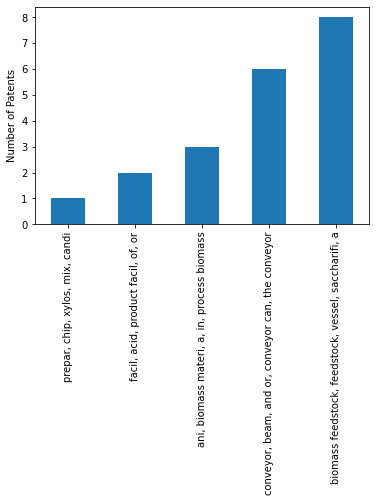

In [58]:
patent_counts_df=patent_topic_details(MM_patents_pA)
patent_counts_df.plot(kind='bar', legend=None)
plt.ylabel('Number of Patents')
plt.savefig('MM_after_post_ARRA.png', bbox_inches='tight')
plt.show()

we can see most renewable energy related topic of these 2 top PI is biomass. 
try a different approach that filtering only the biomass related patents

# filter these top 2 PI with biomass

JBP after ARRA

In [81]:
BIO_JPB_patents_A_abstracts=JPB_patents_A[JPB_patents_A['patent_abstract'].str.contains("biomass|bosfuel")]
BIO_JPB_patents_A_abstracts_list = BIO_JPB_patents_A_abstracts['patent_abstract'].values.tolist()
vectorizer=n_grams_vectorizer(2) #choose number of n-grams
doctopic, ls_keywords=topic_generator(BIO_JPB_patents_A_abstracts_list, 5) 

0 fluid, outlet, communic, fluid communic, in fluid
1 biomass solid, cellulos, cellulos biomass, digest, solid
2 have, time, catalyst, have a, support
3 support, stabil, phase stabil, stabil test, test
4 hydrocatalyt, hydrotherm hydrocatalyt, the biomass, that, hydrotherm


view the one of the abstract of JBP in the after ARRA period

In [94]:
BIO_JPB_patents_A_abstracts_list[0]

'a process for producing biofuels from biomass is provided by removing sulfur compounds and nitrogen compounds from the biomass by contacting the biomass with a digestive solvent to form a pretreated biomass containing soluble carbohydrates and having less than 35% of the sulfur content and less than 35% of the nitrogen content, based on untreated biomass on a dry mass basis, prior to carrying out aqueous phase reforming and further processing to form a liquid fuel.'

JBP after post ARRA

In [82]:
BIO_JPB_patents_pA_abstracts=JPB_patents_pA[JPB_patents_pA['patent_abstract'].str.contains("biomass|bosfuel")]
BIO_JPB_patents_pA_abstracts_list = BIO_JPB_patents_pA_abstracts['patent_abstract'].values.tolist()
vectorizer=n_grams_vectorizer(2) #choose number of n-grams
doctopic, ls_keywords=topic_generator(BIO_JPB_patents_pA_abstracts_list, 5) 

0 further, product, molecular weight, weight compound, unconvert
1 continu, the continu, continu liquid, phase, gas
2 phase, biomass solid, solid, phenol liquid, the cellulos
3 mixtur, product mixtur, least one, reaction, one
4 the biomass, hydrocatalyt, hydrotherm hydrocatalyt, hydrotherm, that


compare the abstract of JBP in the after ARRA period and post ARRA period

In [95]:
BIO_JPB_patents_pA_abstracts_list[0]

'digestion of cellulosic biomass solids may be complicated by release of lignin therefrom. methods for digesting cellulosic biomass solids may comprise: providing cellulosic biomass solids in a digestion solvent; at least partially converting the cellulosic biomass solids into a phenolics liquid phase comprising lignin, an aqueous phase comprising an alcoholic component derived from the cellulosic biomass solids, and an optional light organics phase; and separating the phenolics liquid phase from the aqueous phase.'

MM after ARRA

In [83]:
BIO_MM_patents_A_abstracts=MM_patents_A[MM_patents_A['patent_abstract'].str.contains("biomass|bosfuel")]
BIO_MM_patents_A_abstracts_list = BIO_MM_patents_A_abstracts['patent_abstract'].values.tolist()
vectorizer=n_grams_vectorizer(2) #choose number of n-grams
doctopic, ls_keywords=topic_generator(BIO_MM_patents_A_abstracts_list, 5) 

0 cool, conveyor, the biomass, conveyor can, the conveyor
1 sand, materi such, materi, and or, or
2 feedstock, to produc, biomass feedstock, saccharifi, a
3 facil, product facil, transport, ethanol product, made
4 the product, product of, of, by ferment, g the


view the one of the abstract of MM in the after ARRA period

In [96]:
BIO_MM_patents_A_abstracts_list[0]

'materials such as biomass (e.g., plant biomass, animal biomass, and municipal waste biomass) and hydrocarbon-containing materials are processed to produce useful products, such as fuels. for example, systems are described that can use feedstock materials, such as cellulosic and/or lignocellulosic materials and/or starchy materials, or oil sands, oil shale, tar sands, bitumen, and coal to produce altered materials such as fuels (e.g., ethanol and/or butanol). the processing includes exposing the materials to an ion beam.'

MM after post ARRA

In [84]:
BIO_MM_patents_pA_abstracts=MM_patents_pA[MM_patents_pA['patent_abstract'].str.contains("biomass|bosfuel")]
BIO_MM_patents_pA_abstracts_list = BIO_MM_patents_pA_abstracts['patent_abstract'].values.tolist()
vectorizer=n_grams_vectorizer(2) #choose number of n-grams
doctopic, ls_keywords=topic_generator(BIO_MM_patents_pA_abstracts_list, 5) 

0 ani, biomass materi, a, in, process biomass
1 biomass feedstock, feedstock, vessel, saccharifi, a
2 facil, acid, product facil, of, or
3 prepar, chip, xylos, mix, candi
4 conveyor, beam, and or, conveyor can, the conveyor


compare the abstract of MM in the after ARRA period and post ARRA period

In [99]:
BIO_MM_patents_pA_abstracts_list[0]

'biomass feedstocks (e.g., plant biomass, animal biomass, and municipal waste biomass) are processed to produce useful products, such as fuels. for example, systems are described that can convert feedstock materials to a sugar solution, which can then be fermented to produce ethanol. biomass feedstock is saccharified in a vessel by operation of a jet mixer, the vessel also containing a fluid medium and a saccharifying agent.'

## Linked Grant and Patent Datasets (renewables)
**LDA Exploration Analysis**

In [ ]:
#need to do LDA, tokenization method on patent abstracts and form topics
#do LDA on both the linked data set and nonlinked dataset
merged_df=pd.read_csv('2010_2018_mergedclimate_patent_grants.csv', skipinitialspace=True)
merged_df.head()

In [ ]:
patent_abstract_list=merged_df['patent_abstract'].values.tolist()
patent_abstract_list[3]

In [ ]:
vectorizer = CountVectorizer(analyzer="word",        # unit of features are single words rather than characters
                            tokenizer=tokenize,      # function to create tokens
                            ngram_range=(0,1),       # unigrams - single words
                            strip_accents='unicode', # remove accent characters
                            min_df = 0.05,           # only include words with minimum frequency of 0.05
                            max_df = 0.95)           # only include words with maximum frequency of 0.95

In [ ]:
#remove punctuation
patent_abstract_list[3].translate(translator)

In [ ]:
#LDA TF-IDF model process to generate topics
#how to optimize the n_grams and n_components for more meaningful topics?
#solar seems to be appearing a lot
stop = stop_words + ['provid', 'use', 'studi', 'and', 'the', 'was', 'with', 'of', 'has', 'have', 'had', 'will', 
                     'an', 'may', 'a', 'or', 'be', 'to', 'to the', 'and the', 'embodi', 'may be',
                    'coupl to the', 'coupl', 'coupl to', 'of a']
full_stopwords = [tokenize(s)[0] for s in stop]

translator=str.maketrans(string.punctuation, ' ' * len(string.punctuation))
string.punctuation
stemmer = SnowballStemmer("english")
vectorizer = CountVectorizer(analyzer="word",        # unit of features are single words rather than characters
                            tokenizer=tokenize,      # function to create tokens
                            ngram_range=(0,10),       # change num of words co-located
                            strip_accents='unicode', # remove accent characters
                            min_df = 0.05,           # only include words with minimum frequency of 0.05
                            max_df = 0.95)           # only include words with maximum frequency of 0.95

# Creating bag of words
bag_of_words = vectorizer.fit_transform(patent_abstract_list)  # transform our corpus as a bag of words
features = vectorizer.get_feature_names()                # get features (words)

# Use TfidfTransformer to re-weight bag of words
transformer = TfidfTransformer(norm = None, smooth_idf = True, sublinear_tf = True)
tfidf = transformer.fit_transform(bag_of_words)

# Fitting LDA model
lda = LatentDirichletAllocation(n_components = 9, learning_method='online') #adjust n_components
doctopic = lda.fit_transform(tfidf)

# Displaying the top keywords in each topic
ls_keywords = []
for i,topic in enumerate(lda.components_):
    word_idx = np.argsort(topic)[::-1][:5]
    keywords = ', '.join(features[i] for i in word_idx)
    ls_keywords.append(keywords)
    print(i, keywords)

## Interpretability optimization of Topic Modeling

Extra exploration

In [ ]:
patent_abstract_LL=merged_df['patent_abstract'].to_list()
#form a list of tokenized abstracts; tokenize function generates a list of words
pa_LL=[tokenize(x) for x in patent_abstract_LL]
id2word=gensim.corpora.Dictionary(pa_LL) #dictionary
corpus=[id2word.doc2bow(text) for text in pa_LL]
lda_model=gensim.models.LdaModel(corpus=corpus, num_topics=10)

In [ ]:
goodLdaModel = LdaModel(corpus=corpus, id2word=id2word, iterations=50, num_topics=10)
badLdaModel = LdaModel(corpus=corpus, id2word=id2word, iterations=12, num_topics=10)

In [ ]:
#coherence = u_mass or c_v 
#https://radimrehurek.com/gensim/models/coherencemodel.html 
goodcm = CoherenceModel(model=goodLdaModel, corpus=corpus, dictionary=id2word, coherence='u_mass')
badcm = CoherenceModel(model=badLdaModel, corpus=corpus, dictionary=id2word, coherence='u_mass')

In [ ]:
print(goodcm)

In [ ]:
try:
    raise ImportError
    import pyLDAvis.gensim
    CAN_VISUALIZE = True
    pyLDAvis.enable_notebook()
    from IPython.display import display
except ImportError:
    ValueError("SKIP: please install pyLDAvis")
    CAN_VISUALIZE = False

In [ ]:
if CAN_VISUALIZE:
    prepared = pyLDAvis.gensim.prepare(goodLdaModel, corpus, id2word)
    display(pyLDAvis.display(prepared))
if CAN_VISUALIZE:
    prepared = pyLDAvis.gensim.prepare(badLdaModel, corpus, id2word)
    display(pyLDAvis.display(prepared))

In [ ]:
print('goodcm:', goodcm.get_coherence())
print('badcm:', badcm.get_coherence())

In [ ]:
#if this method done on the original patents dataframe without pre-filtering it may give too broad of topics 
ngram = list(range(2,11)) 
num_topics = list(range(5,20))

for n in ngram:
    for t in num_topics: 
        vectorizer=n_grams_vectorizer(n)
        ls_keywords=topic_generator(patent_abstract_list, t)
        topics_doc = pd.DataFrame(doctopic, columns = ls_keywords)

In [ ]:
t_val=[]
coherence_val=[]
for t in num_topics:    
    patent_abstract_LL=merged_df['patent_abstract'].to_list()
    #form a list of tokenized abstracts; tokenize function generates a list of words
    pa_LL=[tokenize(x) for x in patent_abstract_LL]
    id2word=gensim.corpora.Dictionary(pa_LL) #dictionary
    corpus=[id2word.doc2bow(text) for text in pa_LL]
    x_LdaModel = LdaModel(corpus=corpus, id2word=id2word, iterations=50, num_topics=t)
    x_cm = CoherenceModel(model=x_LdaModel, corpus=corpus, dictionary=id2word, coherence='u_mass')
    t_val.append(t)
    coherence_val.append(x_cm.get_coherence())
max_coherence_val_idx=np.argmax(coherence_val)
max_coherence=coherence_val[max_coherence_val_idx]
best_t=t_val[max_coherence_val_idx]
print('best t: ',best_t, 'best coherence val:', max_coherence)

INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : built Dictionary(1036 unique tokens: ['a', 'an', 'and', 'around', 'articul']...) from 94 documents (total 10735 corpus positions)
INFO : Dictionary lifecycle event {'msg': "built Dictionary(1036 unique tokens: ['a', 'an', 'and', 'around', 'articul']...) from 94 documents (total 10735 corpus positions)", 'datetime': '2022-03-14T18:39:30.189426', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
INFO : using symmetric alpha at 0.2
INFO : using symmetric eta at 0.2
INFO : using serial LDA version on this node
INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 94 documents, updating model once every 94 documents, evaluating perplexity every 94 documents, iterating 50x with a convergence threshold of 0.001000
INFO : -7.801 per-word bound, 223.0 perplexity estimate based 

best t:  6 best coherence val: -1.285336736468702


In [ ]:
#idea is maybe to get LDA topics of patents, and then see the linkage they have with the grants
#change this with LDA version of patents 
RE_text=pd.read_csv('RE_topics_project_id_with_max.csv', skipinitialspace=True)

wanted_topics=[
 'grid, smart, power, control, electr',
 'solar, solar cell, cell, photovolta, light',
 'biomass, fuel, biofuel, product, foundat intellectu',
 'polici, climat, chang, econom, health',
 'energi effici, effici, commerci, hardwar, small',
 'wireless, storag, energi storag, mobil, batteri',
 'wind, turbin, farm, crop, long term',
 'membran, treatment, heat, water, separ']

RE_df_list=[]
#further filtering done to be specific
for t in wanted_topics:
    RE_df_list.append(RE_text[(RE_text['topic']==t) & 
                              (RE_text['PROJECT_TITLE'].str.contains('ENERGY')) &
                               (RE_text['ABSTRACT'].str.contains('renewable | sustainable'))])
full_RE_df=pd.concat(RE_df_list)

REs_df=full_RE_df.copy()
#Spread of Total Funding per year
#specify topic
for w_t in wanted_topics:
    REs_current_df=REs_df[REs_df['topic']==w_t]
    spfcRE_df=REs_current_df.groupby('FY')['FY_TOTAL_COST'].sum().to_frame().reset_index()
    g=sns.barplot(x='FY', y='FY_TOTAL_COST', data=spfcRE_df, color='orange')
    g.set_xticklabels(labels=g.get_xticklabels(), rotation = 35)
    f = ticker.ScalarFormatter(useOffset=False, useMathText=True)
    mapper = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(mapper))
    plt.title('topic: '+str(w_t)+' | across fiscal years')
    plt.show()